DATASET

In [159]:
import pandas as pd

df = pd.read_csv('./prison_corpus.tsv', sep='\t', header=0)

In [160]:
df

,Unnamed: 0,year,issue,topic,article,text
0,0,2009,2,fa’ la cosa giusta,Un post-it per parlare col carcere,Un post-it per parlare col carcere una fiera ...
1,1,2009,2,fa’ la cosa giusta,Made in galera ricetta di successo,"Made in galera, ricetta di successo fà la cos..."
2,2,2009,2,fa’ la cosa giusta,"Equo & solidale, occhio ai prezzi","Equo & solidale, occhio ai prezzi Consumare m..."
3,3,2009,2,fa’ la cosa giusta,Quando l’immaginazione dà libertà,Quando l’immaginazione dà libertà I detenuti ...
4,4,2009,2,fa’ la cosa giusta,È la stampa bellezza e assomiglia all’Italia,È la stampa bellezza e assomiglia tanto all’It...
...,...,...,...,...,...,...
1868,1868,2024,2,"Il Brigantino, una collana corsara",Lo dirige Irina Bajini,"Lo dirige Irina Bajini Il Brigantino, che ha ..."
1869,1869,2024,2,"Il Brigantino, una collana corsara",lo coordina Giovanni Baiocchetti,"Il Brigantino, che ha sede nel IV reparto dell..."
1870,1870,2024,1,Giustizia & carcere,False dichiarazioni degli extracomunitari prov...,Il numero degli stranieri detenuti a Bollate è...
1871,1871,2024,1,Giustizia & carcere,Senza identità e senza diritti,Il numero degli stranieri detenuti a Bollate è...


In [161]:
grouped = df.groupby("topic")["text"].agg(" ".join).reset_index()
grouped

,topic,text
0,#iorEstoincElla,"Io, in cella da solo per 15 giorni Queste rif..."
1,A riempire una stanza,A riempire una stanza basta una caffettiera su...
2,Adriano Sofri,"La biografia di Beppe La Monica, scritta da Ti..."
3,Animali in gabbia,"Il nostro coniglio non sta in gabbia, come tut..."
4,Attualità,Lucia Castellano la conosciamo tutti. Quando d...
...,...,...
186,storiE,"L’orso M49, l'orso più fuggitivo d’Italia, sca..."
187,stranieri,Migliaia di migranti rinchiusi in centri disum...
188,suicidi,I giornali raccontano le storie di compagni di...
189,tEstimonianzE,"Ho visto l’inferno Le cose che sto per dire, ..."


EXPLORATIVE DATA ANALYSIS

In [162]:
import statistics

def explorative_analysis(documents: list[str]) -> tuple[float, float]:
  count_word_in_sentences = []
  count_sentence_in_docs = []

  for doc in documents:
    num_sen = len([sen for sen in doc.split('.')])
    count_sentence_in_docs.append(num_sen)
    for sen in doc.split('.'):
      num_word = len([word for word in sen.split(' ')])
      count_word_in_sentences.append(num_word)

  return [statistics.mean(count_word_in_sentences), statistics.mean(count_sentence_in_docs)]


In [163]:
explorative_analysis(df['text']), explorative_analysis(df['article'])

([27.453345734251673, 21.239722370528565],
 [4.972433460076045, 1.1233315536572344])

In [164]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [165]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#This function preprocesses the text given in input
def preprocess_text(text: str) -> str:
    stop_words = set(stopwords.words('italian'))
    lemmatizer = WordNetLemmatizer()

    tokens = word_tokenize(text, language='italian')
    cleaned_tokens = [
        lemmatizer.lemmatize(word.lower())
        for word in tokens
        if word.isalnum() and word.lower() not in stop_words and word not in string.punctuation
    ]

    return " ".join(cleaned_tokens)

In [166]:
def get_cleaned_documents(column: str):
  return [preprocess_text(doc) for doc in df[column]]

In [167]:
cleaned_text_documents = get_cleaned_documents('text')
cleaned_article_documents = get_cleaned_documents('article')

ESTRAZIONE KEYWORDS

In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_keywords_tfidf(texts, top_n=15):
    # Preprocess the text
    preprocessed_texts = [preprocess_text(text) for text in texts]

    # Vectorize the text with TF-IDF
    vectorizer = TfidfVectorizer(max_features=top_n)
    tfidf_matrix = vectorizer.fit_transform(preprocessed_texts)

    # Get the feature names (words) and sort by importance (TF-IDF score)
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1

    # Create a list of (word, score) tuples
    word_scores = list(zip(feature_names, scores))
    word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)

    # Extract the top N keywords
    keywords = [(word, score) for word, score in word_scores[:top_n]]
    return keywords

In [169]:
kw_text = extract_keywords_tfidf(cleaned_text_documents)
kw_article = extract_keywords_tfidf(cleaned_article_documents, 3)

ESTRAZIONE N-GRAMS

In [170]:
from sklearn.feature_extraction.text import CountVectorizer

def generate_n_grams(texts, ngram = 3, top_n = 25):
  # Initialize CountVectorizer for ngrams
  vectorizer = CountVectorizer(ngram_range=(ngram, ngram), stop_words=stopwords.words('italian'))

  # Fit and transform the text
  X = vectorizer.fit_transform(texts)

  # Get n-gram feature names and their counts
  ngrams = vectorizer.get_feature_names_out()
  counts = X.toarray().sum(axis=0)

  # Sort and display the most common ngrams
  sorted_ngrams = sorted(zip(ngrams, counts), key=lambda x: x[1], reverse=True)

  return sorted_ngrams[:top_n]

VISUALIZZAZIONE KEYWORDS

In [171]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordcloud(text):
    wordcloud = WordCloud(width = 500, height = 500, background_color = "white").generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    return wordcloud

In [172]:
kw_text_dict = dict(kw_text)
kw_article_dict = dict(kw_article)

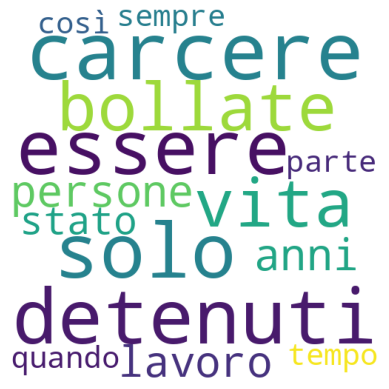

In [173]:
generate_wordcloud(" ".join(list(kw_text_dict.keys())))

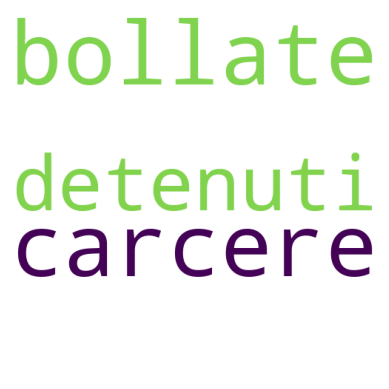

In [174]:
generate_wordcloud(" ".join(list(kw_article_dict.keys())))

COMPARE

In [175]:
def compare_words(kw1, kw2):
   # Common keywords (intersection)
  common_keywords = set(kw1.keys()) & set(kw2.keys())

  # Unique keywords in each analysis
  unique_to_1 = set(kw1.keys()) - set(kw2.keys())
  unique_to_2 = set(kw2.keys()) - set(kw1.keys())

  print(f"Common keywords: {common_keywords}")
  print(f"Unique text keywords: {unique_to_1}")
  print(f"Unique article keywords: {unique_to_2}")

In [176]:
compare_words(kw_text_dict, kw_article_dict)

Common keywords: {'carcere', 'bollate', 'detenuti'}
Unique text keywords: {'tempo', 'essere', 'sempre', 'stato', 'vita', 'quando', 'persone', 'solo', 'anni', 'così', 'parte', 'lavoro'}
Unique article keywords: set()


In [177]:
def compare_score(kw1, kw2):
  common_keywords = set(kw1.keys()) & set(kw2.keys())

  # Normalize score for better visualization
  text_score_array = list(kw1.values())
  article_score_array = list(kw2.values())
  text_mean = statistics.mean(text_score_array)
  article_mean = statistics.mean(article_score_array)
  text_standard_deviation = statistics.stdev(text_score_array)
  article_standard_deviation = statistics.stdev(article_score_array)

  # Compare scores for common keywords
  score_comparison = {
    word: (abs((kw1[word] - text_mean) / text_standard_deviation), abs((kw2[word] - article_mean) / article_standard_deviation))
    for word in common_keywords
  }

  # Create DataFrame for comparison
  df = pd.DataFrame(score_comparison, index=["Text", "Article"]).T

  # Plot bar chart
  df.plot(kind="bar", figsize=(10,5), title="Keyword Score Comparison")
  plt.ylabel("TF-IDF Score")
  plt.xticks(rotation=45)
  plt.grid()
  plt.show()

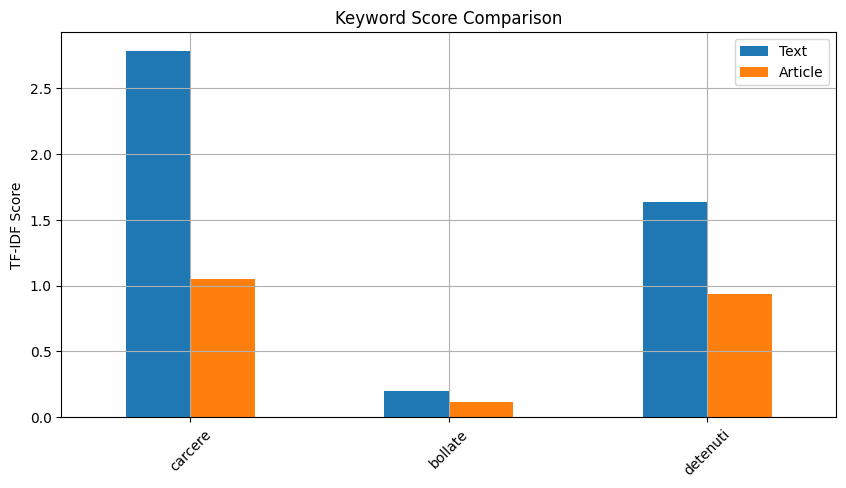

In [178]:
compare_score(kw_text_dict, kw_article_dict)

In [179]:
from sklearn.metrics.pairwise import cosine_similarity

def compare_similarity(kw1, kw2):
  # Convert keywords to a single string
  text_1 = " ".join(kw1.keys())
  text_2 = " ".join(kw2.keys())

  # Compute TF-IDF and similarity
  vectorizer = TfidfVectorizer()
  tfidf_matrix = vectorizer.fit_transform([text_1, text_2])
  similarity = cosine_similarity(tfidf_matrix)[0, 1]

  print(f"Keyword Similarity Score: {similarity:.2f}")

In [180]:
compare_similarity(kw_text_dict, kw_article_dict)

Keyword Similarity Score: 0.34


ANALISI LESSICALE

In [181]:
explorative_analysis(df['text'])

[27.453345734251673, 21.239722370528565]

In [182]:
!python -m spacy download it_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.9/567.9 MB 1.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [183]:
pip install networkx

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


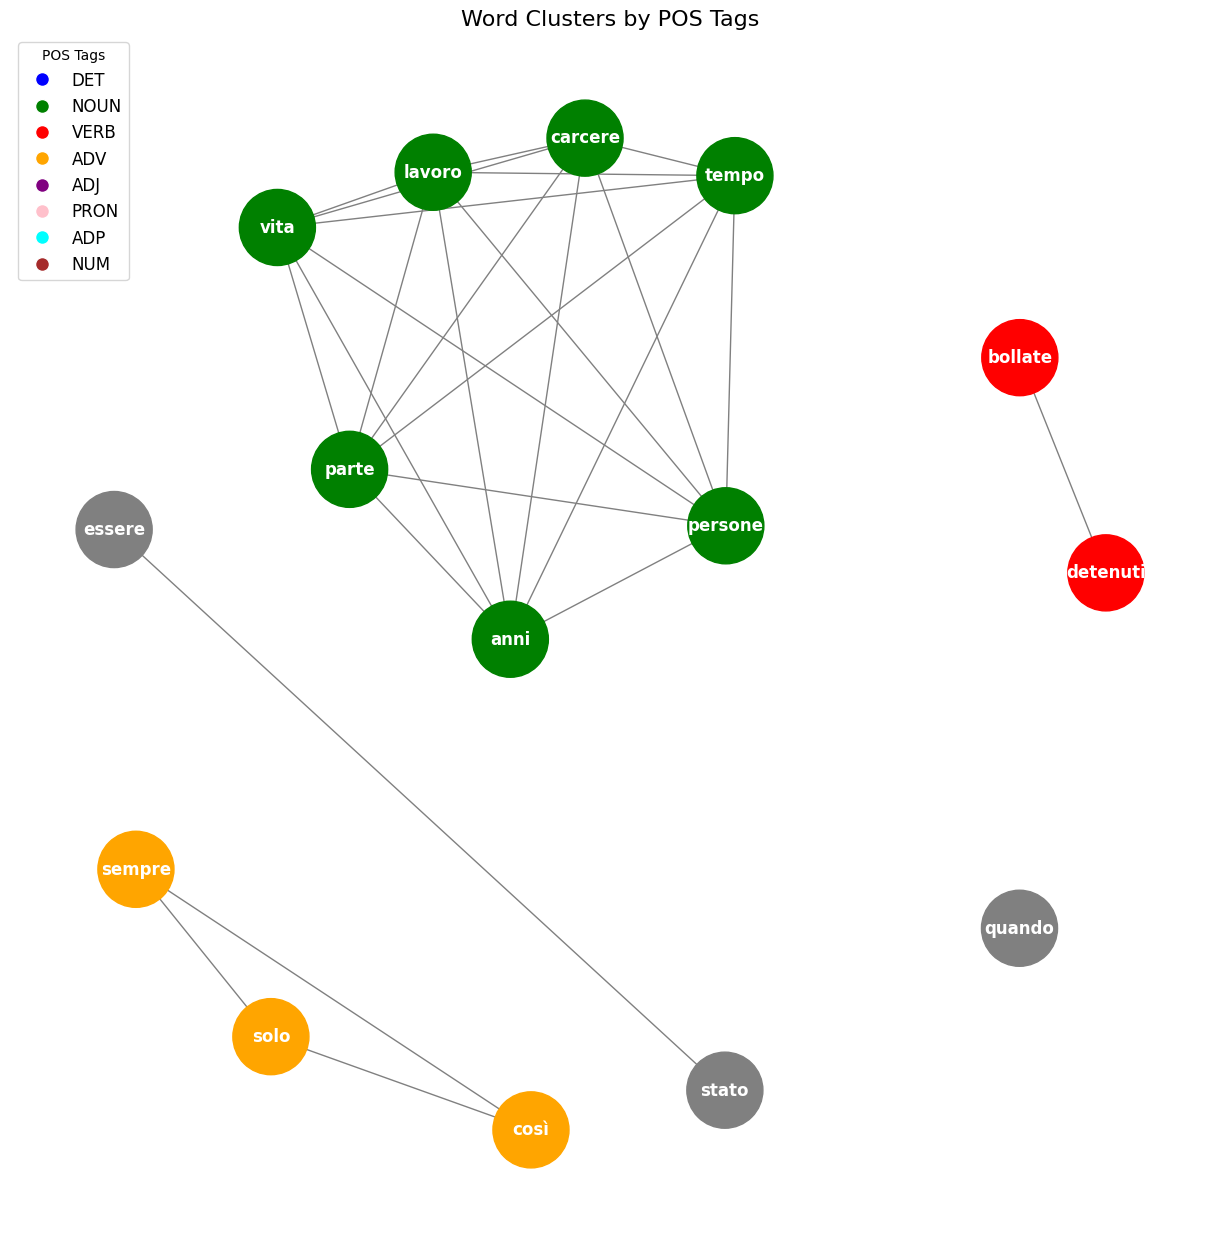

In [184]:
import spacy
import networkx as nx

# Load the Italian spaCy model
nlp = spacy.load("it_core_news_lg")

# Example text (replace with your cleaned text documents)
text = " ".join(list(kw_text_dict.keys()))

# Process the text with spaCy to get the POS tagging
doc = nlp(text)

# Create a graph
G = nx.Graph()

# Add nodes with word and POS tag as attributes
for token in doc:
    G.add_node(token.text, pos=token.pos_)

# Add edges between words with the same POS tag to form clusters
for token1 in doc:
    for token2 in doc:
        if token1 != token2 and token1.pos_ == token2.pos_:
            G.add_edge(token1.text, token2.text)

# Define a color map for POS tags
color_map = {
    "DET": "blue",      # Determiners
    "NOUN": "green",    # Nouns
    "VERB": "red",      # Verbs
    "ADV": "orange",    # Adverbs
    "ADJ": "purple",    # Adjectives
    "PRON": "pink",     # Pronouns
    "ADP": "cyan",      # Adpositions (Prepositions, Conjunctions)
    "NUM": "brown"      # Numerals
}

# Assign colors based on POS tags
node_colors = [color_map.get(G.nodes[node]["pos"], "gray") for node in G.nodes]

layout = nx.spring_layout(G, seed=42, k=10, iterations=300)

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=True, node_color=node_colors, font_weight="bold", node_size=3000, font_size=12, font_color="white", edge_color="gray", pos=layout)

# Add title
plt.title("Word Clusters by POS Tags", fontsize=16)

# Add the legend for the POS tags and their respective colors
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[pos], markersize=10) for pos in color_map]
labels = [pos for pos in color_map]
plt.legend(handles=handles, labels=labels, title="POS Tags", loc="upper left", fontsize=12)

# Display the plot
plt.show()

ANALISI SENTIMENTALE

In [185]:
def split_into_chunks(text: str, max_length: int = 520) -> list:
    """Split a long document into chunks of size max_length."""
    tokens = word_tokenize(text)  # Tokenize the document
    return [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]


In [186]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from collections import Counter

def analyze_sentiment(text, device=-1):  # device=-1 means CPU, device=0 for GPU
    model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

    LABEL_MAPPING = {
      "1 star": "Very Negative",
      "2 stars": "Negative",
      "3 stars": "Neutral",
      "4 stars": "Positive",
      "5 stars": "Very Positive"
    }

    # Load the model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Initialize the sentiment analysis pipeline
    sentiment_analyzer = pipeline('sentiment-analysis',
                                  model=model,
                                  tokenizer=tokenizer,
                                  device=device)

    # Analyze sentiment
    res = [{ "sentiment": LABEL_MAPPING[item["label"]], "score": item["score"] } for item in sentiment_analyzer(text)]

    return res


In [187]:
from collections import defaultdict

def process_sentiment_analysis(cleaned_text_documents: list, max_length: int = 520):
    """Process sentiment analysis on each document, splitting if necessary,
    and calculate the mean score for each sentiment group."""

    sentiment_results = []

    for doc in cleaned_text_documents:
        chunks = split_into_chunks(doc, max_length)  # Split the doc into chunks
        chunk_sentiments = [analyze_sentiment(" ".join(chunk)) for chunk in chunks]  # Analyze sentiment for each chunk

        print(chunk_sentiments)

        # Group sentiment results by sentiment type
        sentiment_groups = defaultdict(list)

        for sentiment in chunk_sentiments:
            sentiment_groups[sentiment[0]['sentiment']].append(sentiment[0]['score'])

        # Calculate the mean score for each sentiment group
        for sentiment, scores in sentiment_groups.items():
            avg_score = sum(scores) / len(scores)  # Mean score for this sentiment
            sentiment_results.append({'sentiment': sentiment, 'avg_score': avg_score})

    return sentiment_results


In [188]:
sentiment_analysis = [analyze_sentiment(doc[0:520]) for doc in cleaned_text_documents]

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set

In [189]:
sentiment_analysis

[[{'sentiment': 'Very Negative', 'score': 0.6470049023628235}],
 [{'sentiment': 'Very Positive', 'score': 0.6168013215065002}],
 [{'sentiment': 'Negative', 'score': 0.36121171712875366}],
 [{'sentiment': 'Negative', 'score': 0.3091316819190979}],
 [{'sentiment': 'Very Positive', 'score': 0.23115837574005127}],
 [{'sentiment': 'Positive', 'score': 0.7799288034439087}],
 [{'sentiment': 'Very Negative', 'score': 0.35762685537338257}],
 [{'sentiment': 'Very Negative', 'score': 0.7391000390052795}],
 [{'sentiment': 'Very Negative', 'score': 0.30715617537498474}],
 [{'sentiment': 'Positive', 'score': 0.2907734811306}],
 [{'sentiment': 'Very Negative', 'score': 0.4429323971271515}],
 [{'sentiment': 'Neutral', 'score': 0.36084654927253723}],
 [{'sentiment': 'Very Negative', 'score': 0.5513079762458801}],
 [{'sentiment': 'Very Negative', 'score': 0.7356628775596619}],
 [{'sentiment': 'Very Negative', 'score': 0.7425426244735718}],
 [{'sentiment': 'Very Negative', 'score': 0.46166935563087463}],

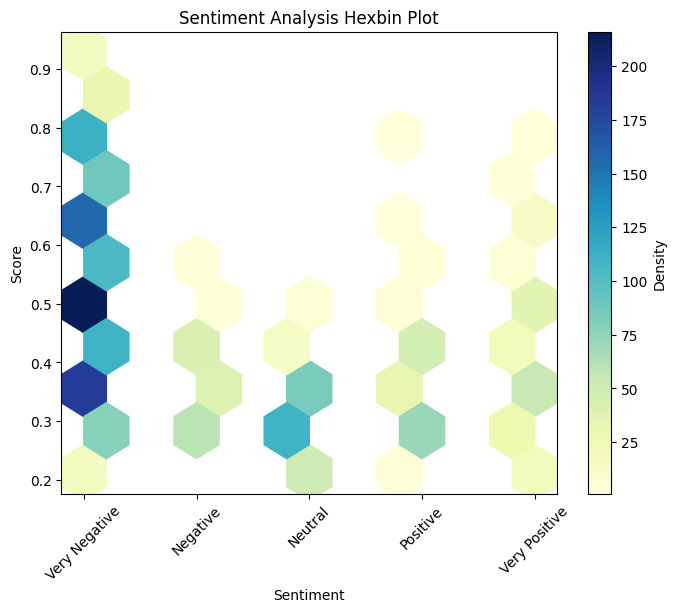

In [190]:
import numpy as np

# Sentiment mapping
sentiment_mapping = {
    "Very Negative": 0,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3,
    "Very Positive": 4
}

# Set to x the sentiment and to y the scores
x_values = [sentiment_mapping[item["sentiment"]] for sublist in sentiment_analysis for item in sublist]
y_values = [item["score"] for sublist in sentiment_analysis for item in sublist]

# Create the hexbin
plt.figure(figsize=(8, 6))
plt.hexbin(x_values, y_values, gridsize=10, cmap='YlGnBu', mincnt=1)

# Add density bar
plt.colorbar(label='Density')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Score')
plt.title('Sentiment Analysis Hexbin Plot')

# Adjust rotation
plt.xticks(np.arange(5), ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'], rotation=45)

# Show plot
plt.show()